
Congrats....again! Based off the amazing work you did on the classification model, you've been promoted to chief of all data scientists in Hollywood, your a total celebrity....among data scientists :).  

Your boss, head of the studio, has now asked you to build a model to predict gross revenue in order to help them decide which movies to invest in.

Once again, you would like to be able to explain the model to mere mortals but need a fairly robust and flexible approach so you've chosen to use decision trees to get started. 

In doing so...you leverage work you've done in the past to get the job done....you're a data scientist after all! 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
from sklearn.model_selection import train_test_split,GridSearchCV, RepeatedKFold
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor, export_graphviz 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import OrdinalEncoder
# from sklearn.tree import DecisionTreeClassifier, export_graphviz 
from sklearn.tree import plot_tree

In [2]:
#1. Load the data
#Sometimes need to set the working directory back out of a folder that we create a file in

#import os
#os.listdir()
#print(os.getcwd())
#os.chdir('c:\\Users\\Brian Wright\\Documents\\3001Python\\DS-3001')

movie_metadata=pd.read_csv("../data/movie_metadata.csv")
movie_metadata.head()



,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0


#2 Ensure all the variables are classified correctly and collapse factor variables as needed.

In [3]:
def preprocess(df):
    # Drop Columns with too many unique values
    # Keeping gross revenue as the target variable
    df = df.drop(columns=['actor_1_name','actor_2_name','color','content_rating','actor_3_name','plot_keywords','movie_imdb_link'])

    # Collapse imdb score (target variable) into two classes 
    # name for new target variable is imdb_score_cat
    df['imdb_score_cat'] = pd.cut(df['imdb_score'], bins=[0, 7, 10], labels=[0, 1]).astype(int)
    df = df.drop(columns=['imdb_score'])

    # Classify director names mentioned more than 10 times with 1 and 0
    director_counts = df['director_name'].value_counts()
    df['director_name'] = df['director_name'].apply(lambda x: 1 if director_counts.get(x, 0) > 10 else 0)

    # Classify country mentioned more than 10 times with 1 and 0
    df['country'] = df['country'].apply(lambda x: 1 if director_counts.get(x, 0) > 10 else 0)

    # Classify language mentioned more than 10 times with 1 and 0
    df['language'] = df['language'].apply(lambda x: 1 if director_counts.get(x, 0) > 10 else 0)

    # Separate genres into different columns and encode them with 1 and 0
    genre_dummies = df['genres'].str.get_dummies(sep='|')
    df = df.join(genre_dummies)
    df.drop(columns=['genres'], inplace=True)
    
    return df

movie_metadata2 = preprocess(movie_metadata)

#3 Check for missing variables and correct as needed.

In [4]:
def fix_missing(df):
    # Drop Columns with too many missing values 
    df = df.dropna(thresh = int((1 - 0.4) * len(movie_metadata)), axis=1)
    
    # Drop missing values
    df = df.dropna()
    
    return df

movie_metadata3 = fix_missing(movie_metadata2)

#4 Guess what, you don't need to scale the data, because DTs don't require this to be done, they make local greedy decisions...keeps getting easier, go to the next step.

#5 Determine the variance of the target variable, is it normally distributed? If not, you may want to transform the target variable. Why might this be important?

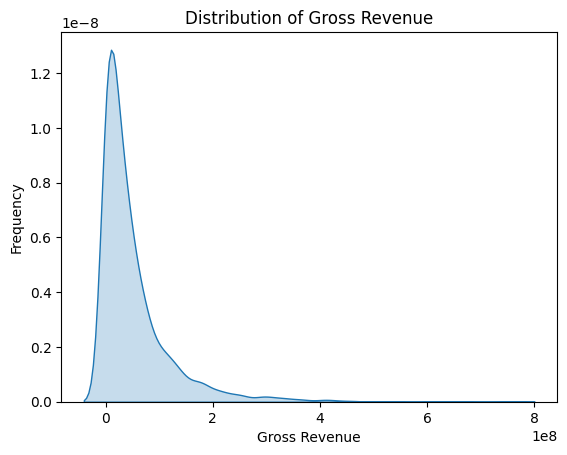

In [5]:
# Check the distribution of the target variable
sns.kdeplot(movie_metadata3, x ='gross', fill=True, common_norm=False)
plt.title('Distribution of Gross Revenue')
plt.xlabel('Gross Revenue')
plt.ylabel('Frequency')
plt.show()


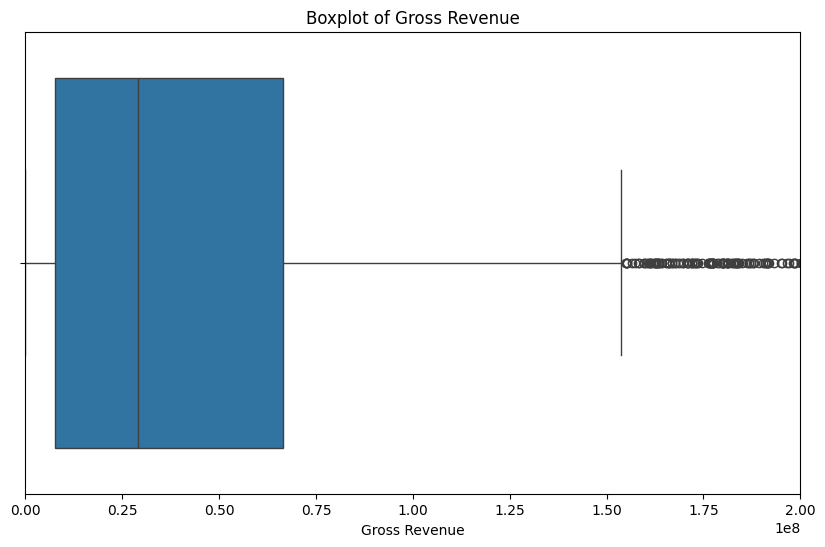

Number of outliers:  295


In [6]:
# check for outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x=movie_metadata3['gross'])
plt.title('Boxplot of Gross Revenue')
plt.xlabel('Gross Revenue')
plt.xlim(0, 2e8)
plt.show()

# count the number of outliers
outliers = movie_metadata3[(movie_metadata3['gross'] > 1.5e8)]
print("Number of outliers: ", len(outliers))


In [7]:
# Drop outliers
movie_metadata4 = movie_metadata3[movie_metadata3['gross'] <= 1.5e8]

/tmp/ipykernel_1103/2536537550.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_metadata4['Log_Gross'] = np.log(movie_metadata4['gross'])


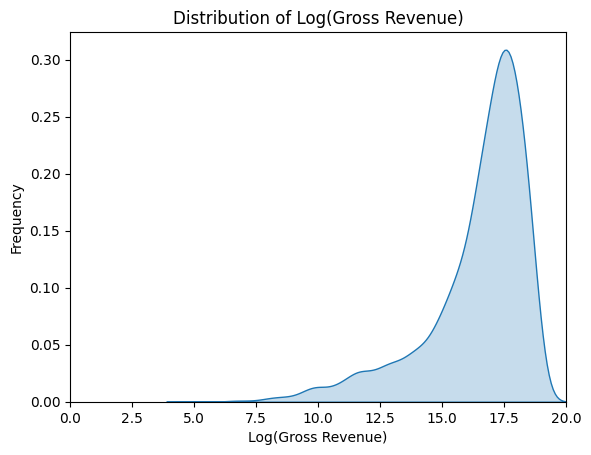

In [8]:
movie_metadata4['Log_Gross'] = np.log(movie_metadata4['gross'])
# Drop gross revenue column
movie_metadata4 = movie_metadata4.drop(columns=['gross'])
# Check the distribution of the target variable
sns.kdeplot(movie_metadata4, x ='Log_Gross', fill=True, common_norm=False)
plt.title('Distribution of Log(Gross Revenue)')
plt.xlabel('Log(Gross Revenue)')
plt.ylabel('Frequency')
plt.xlim(0, 20)
plt.show()

#6 Split your data into test, tune, and train. (80/10/10)

In [9]:
def split_data(df, target, train_size=0.80, tune_size=0.50, random_state=21):
    # Split independent and dependent variables
    # Drop the target variable from the features
    X = df.drop(columns=target)
    y = df[target]
    
    # Split data into training and testing sets
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size = train_size, random_state = random_state)
    
    # Split the temporary set into tuning and testing sets
    X_tune, X_test, y_tune, y_test = train_test_split(X_temp,y_temp, train_size = tune_size, random_state = random_state)
    
    return X_train, X_tune, X_test, y_train, y_tune, y_test

X_train, X_tune, X_test, y_train, y_tune, y_test = split_data(movie_metadata4, 'Log_Gross')

# Drop 'movie_title' column from X_train, X_tune, X_test
X_train2 = X_train.drop(columns=['movie_title']).copy()
X_tune2 = X_tune.drop(columns=['movie_title']).copy()
X_test2 = X_test.drop(columns=['movie_title']).copy()

#7 Create the kfold object for cross validation.

In [10]:
kf = RepeatedKFold(n_splits=10,n_repeats =5, random_state=42) # Define the cross-validation method

#8 Create the scoring metric (several measures) you will use to evaluate your model and choose a hyperparamater to optimize.

In [23]:
scoring = ['neg_mean_squared_error','r2','neg_mean_absolute_error']

param={
    "max_depth" : [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
        }


#9 Build the regression tree object. 

In [24]:
reg=DecisionTreeRegressor(random_state=30)
search = GridSearchCV(reg, param, scoring=scoring, n_jobs=-1, cv=kf,refit='r2')

#10 Fit the model to the training data.

In [25]:
model = search.fit(X_train2, y_train)

#11 Explore the results of the model. Print the output of the grid search. What is the best parameter and score?

Results of the Model

In [28]:
print(model.cv_results_.keys()) # to see the keys in the cv_results_ dictionary

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_max_depth', 'params', 'split0_test_neg_mean_squared_error', 'split1_test_neg_mean_squared_error', 'split2_test_neg_mean_squared_error', 'split3_test_neg_mean_squared_error', 'split4_test_neg_mean_squared_error', 'split5_test_neg_mean_squared_error', 'split6_test_neg_mean_squared_error', 'split7_test_neg_mean_squared_error', 'split8_test_neg_mean_squared_error', 'split9_test_neg_mean_squared_error', 'split10_test_neg_mean_squared_error', 'split11_test_neg_mean_squared_error', 'split12_test_neg_mean_squared_error', 'split13_test_neg_mean_squared_error', 'split14_test_neg_mean_squared_error', 'split15_test_neg_mean_squared_error', 'split16_test_neg_mean_squared_error', 'split17_test_neg_mean_squared_error', 'split18_test_neg_mean_squared_error', 'split19_test_neg_mean_squared_error', 'split20_test_neg_mean_squared_error', 'split21_test_neg_mean_squared_error', 'split22_test_neg_mean_squared_error', 'sp

In [26]:
# Accuracy metrics
mean_sq_err = np.sqrt(abs(model.cv_results_['mean_test_neg_mean_squared_error']))
r2= model.cv_results_['mean_test_r2']
mae= abs(model.cv_results_['mean_test_neg_mean_absolute_error'])

#Standard Deviation:
SDmse =  model.cv_results_['std_test_neg_mean_squared_error']
SDr2= model.cv_results_['std_test_r2']
SDmae= model.cv_results_['std_test_neg_mean_absolute_error']

#Parameter:
depth= np.unique(model.cv_results_['param_max_depth']).data

#Build DataFrame:
final_model = pd.DataFrame(list(zip(depth, mean_sq_err, r2,mae, SDmse,SDr2,SDmae)),
               columns =['depth','rmse','r2','mae',"rmseSD",'r2SD','maeSD'])

print(final_model.head(10))

   depth      rmse        r2       mae    rmseSD      r2SD     maeSD
0      1  1.807148  0.252332  1.312992  0.381621  0.061990  0.058081
1      2  1.686460  0.348645  1.204164  0.350314  0.061330  0.062499
2      3  1.618245  0.399978  1.128683  0.347790  0.066689  0.063880
3      4  1.578910  0.428557  1.082294  0.351582  0.069928  0.063555
4      5  1.570901  0.434061  1.062711  0.348893  0.072554  0.061622
5      6  1.596247  0.415380  1.059736  0.388395  0.084439  0.065123
6      7  1.645793  0.377764  1.067681  0.390147  0.089619  0.063117
7      8  1.694464  0.338334  1.080389  0.363496  0.099625  0.056687
8      9  1.757182  0.287855  1.116767  0.434625  0.120303  0.065962
9     10  1.800134  0.253572  1.145449  0.456870  0.120250  0.073779


Best Parameter

In [ ]:
print(model.best_params_) # Print the best parameters

{'max_depth': 5}


#12 Which variables appear to be contributing the most (variable importance)

In [15]:
varimp=pd.DataFrame(best.feature_importances_,index = X_train2.columns,columns=['importance']).sort_values('importance', ascending=False)
print(varimp)

                           importance
num_voted_users              0.613073
budget                       0.212115
title_year                   0.043017
actor_3_facebook_likes       0.032551
cast_total_facebook_likes    0.019597
num_user_for_reviews         0.016457
actor_2_facebook_likes       0.012948
Family                       0.010209
Crime                        0.008268
War                          0.008247
facenumber_in_poster         0.007916
Horror                       0.007160
aspect_ratio                 0.005805
duration                     0.002636
country                      0.000000
language                     0.000000
num_critic_for_reviews       0.000000
director_name                0.000000
actor_1_facebook_likes       0.000000
director_facebook_likes      0.000000
Adventure                    0.000000
Action                       0.000000
Biography                    0.000000
Animation                    0.000000
Comedy                       0.000000
Documentary 

#13 Create a model object using the best model hyperparameter value from the trained regression tree.

In [29]:
best= model.best_estimator_
print(best)

DecisionTreeRegressor(max_depth=5, random_state=30)


#14 Using the best model predict on the tune data and print out the results.

In [31]:
pred=best.predict(X_tune2)
print(pred[:10])

[16.70906651 16.69695624 17.6047666  15.87645003 16.70906651 16.70906651
 16.69695624 17.21087348 17.68911816 16.69695624]


#15 How does the model perform on the tune data as compared to the training data?

In [35]:
print(best.score(X_tune2, y_tune))

0.3070416977359204


In [32]:
print(best.score(X_train2, y_train))

0.575833272373597


#16 What five movies are predicted to have the lowest gross revenue from the tune set?

In [ ]:
movie_titles = X_tune['movie_title'].values # retrieve movie titles from the original DataFrame
predictions = pd.DataFrame({'movie_title': movie_titles, 'predicted_gross': pred}) # create a DataFrame with movie titles and predicted gross revenue
predictions = predictions.sort_values(by='predicted_gross', ascending=True) # reorder the DataFrame by predicted gross revenue
print(predictions.head(5)) # display 5 movies with lowest gross revenue

             movie_title  predicted_gross
172      Neal 'N' Nikki          8.686485
239          Open Water         10.463711
192  The Last Sin Eater         10.835175
168      Kiss the Bride         10.835175
300        Frozen River         10.951661


#17 As a data scientist you are always looking to improve your results. What are some ideas you have to improve the model? Have you ask...WHAT IF?!

#18 Experiment using your what if ideas (two is fine). Did the model improve? If so, how much? If not, what did you learn? (You don't need to include all the "what if" code just speak to what you tried and what you learned).

#19 Use the best model to predict on the test data and print out the evaluation results.

#20 Does the model perform well on the test data when compared to the training and tune data? Why or why not?

#21 Where are the errors occurring in your predictions? Are they systematic or random? In either case, what are the implications of this?

#22 Summarize what you learned along the way and make recommendations on how this could be used moving forward, being careful not to over promise.